In [1]:
import torch 
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../..'))
from data import SyntheticPV
from models import ExactGP, ApproximateGP
from models import ExactPVLFM, ApproximatePVLFM
from alfi.configuration import VariationalConfiguration
from pv_plot import plot_lfm

In [49]:
dataset = SyntheticPV(num_discrete=3)

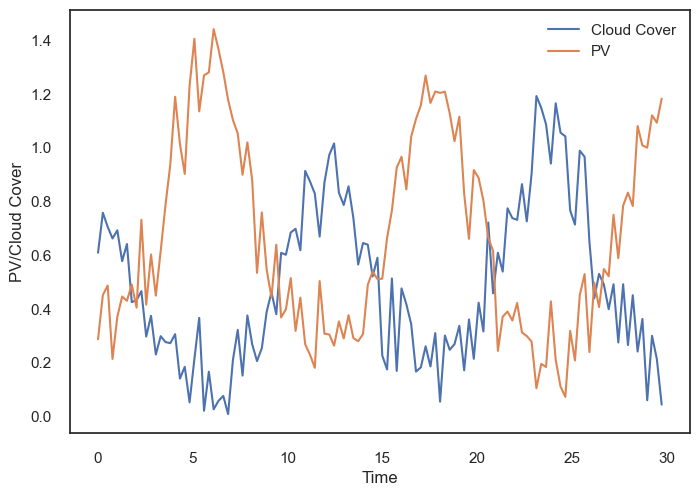

In [50]:
plt.rcParams['font.family'] = 'Arial'
plt.plot(dataset.times, dataset.cloud, label='Cloud Cover')
plt.plot(dataset.times, dataset.pv, label='PV')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PV/Cloud Cover');

In [51]:
num_latents = 1
num_outputs = 1
num_training = dataset.data[0][0].shape[0]
num_inducing = 30

In [52]:
covar = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
mean = gpytorch.means.ZeroMean()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGP(dataset.data[0][0], dataset.data[0][1], mean, covar, likelihood)
config = VariationalConfiguration(num_samples=70)

In [53]:
model = ExactPVLFM(
    dataset=dataset,
    num_outputs=num_outputs,
    gp_model=gp_model,
    config=config,
)
model.fit(n_iter=300)

Iteration 0, loss 61.2259699704816
Iteration 10, loss 10.255479088404892
Iteration 20, loss 2.047595207910265
Iteration 30, loss 2.157413679608638
Iteration 40, loss 1.0718713505733388
Iteration 50, loss 0.7435330053878908
Iteration 60, loss 0.6215546574459179
Iteration 70, loss 0.33179346517680325
Iteration 80, loss 0.1813949207258551
Iteration 90, loss 0.09701858224529614
Iteration 100, loss -0.047414705853548504
Iteration 110, loss -0.09025099506068653
Iteration 120, loss -0.17326096028104565
Iteration 130, loss -0.21604833256265973
Iteration 140, loss -0.3455808063927225
Iteration 150, loss -0.39290105174621304
Iteration 160, loss -0.4098547029189634
Iteration 170, loss -0.45550037948189664
Iteration 180, loss -0.5049137107571537
Iteration 190, loss -0.5725846651303335
Iteration 200, loss -0.56990987761886
Iteration 210, loss -0.5904285032677982
Iteration 220, loss -0.6390766410967872
Iteration 230, loss -0.6370707074889734
Iteration 240, loss -0.672250888098271
Iteration 250, loss

Early stopping of GP


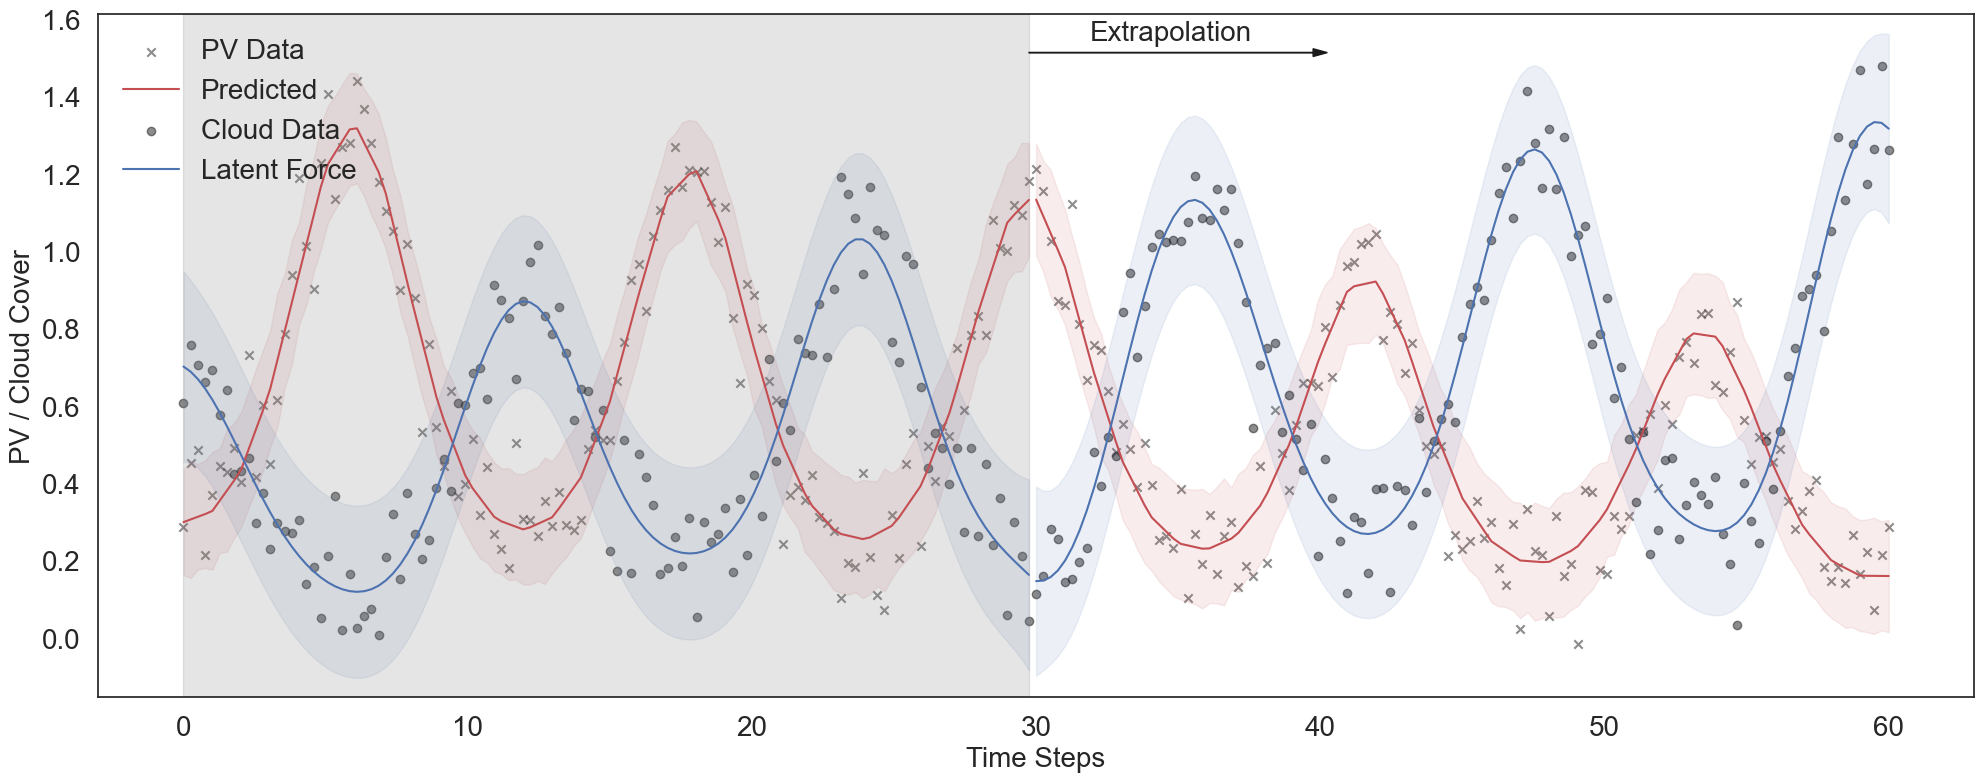

In [54]:
plot_lfm(model, dataset, gp_model)


In [55]:
from gpytorch.means import ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
gp_config = {
    'type' : 'stochastic',
    'name' : 'cholesky',
    'jitter' : 1e-6,
}
gp_model = ApproximateGP(
    dataset,
    ZeroMean(),
    ScaleKernel(RBFKernel()),
    gpytorch.likelihoods.GaussianLikelihood(),
    gp_config
)
config = VariationalConfiguration(num_samples=70)
model = ApproximatePVLFM(dataset=dataset,
        num_outputs=1,
        gp_model=gp_model,
        config=config)
model.fit(n_iter=300)

Iter 1/300, Loss: 58.114227485478544
Iter 11/300, Loss: 9.331083825634906
Iter 21/300, Loss: 2.8022076123159154
Iter 31/300, Loss: 1.5809391329474494
Iter 41/300, Loss: 0.670958074699376
Iter 51/300, Loss: 0.32254229728782974
Iter 61/300, Loss: -0.022940017730313525
Iter 71/300, Loss: -0.02925732863100161
Iter 81/300, Loss: -0.21103816527170047
Iter 91/300, Loss: -0.39668798135539995
Iter 101/300, Loss: -0.45962056286431113
Iter 111/300, Loss: -0.4984464998725072
Iter 121/300, Loss: -0.6287945078676793
Iter 131/300, Loss: -0.6602523102333007
Iter 141/300, Loss: -0.6564668351872827
Iter 151/300, Loss: -0.7532980101395601
Iter 161/300, Loss: -0.7726602712991131
Iter 171/300, Loss: -0.8510922080922851
Iter 181/300, Loss: -0.8781082761511894
Iter 191/300, Loss: -0.9460556071676524
Iter 201/300, Loss: -0.9904731864917226
Iter 211/300, Loss: -1.0596287960187296
Iter 221/300, Loss: -1.0869249398524188
Iter 231/300, Loss: -1.1347693172351592
Iter 241/300, Loss: -1.1430732843737208
Iter 251/300

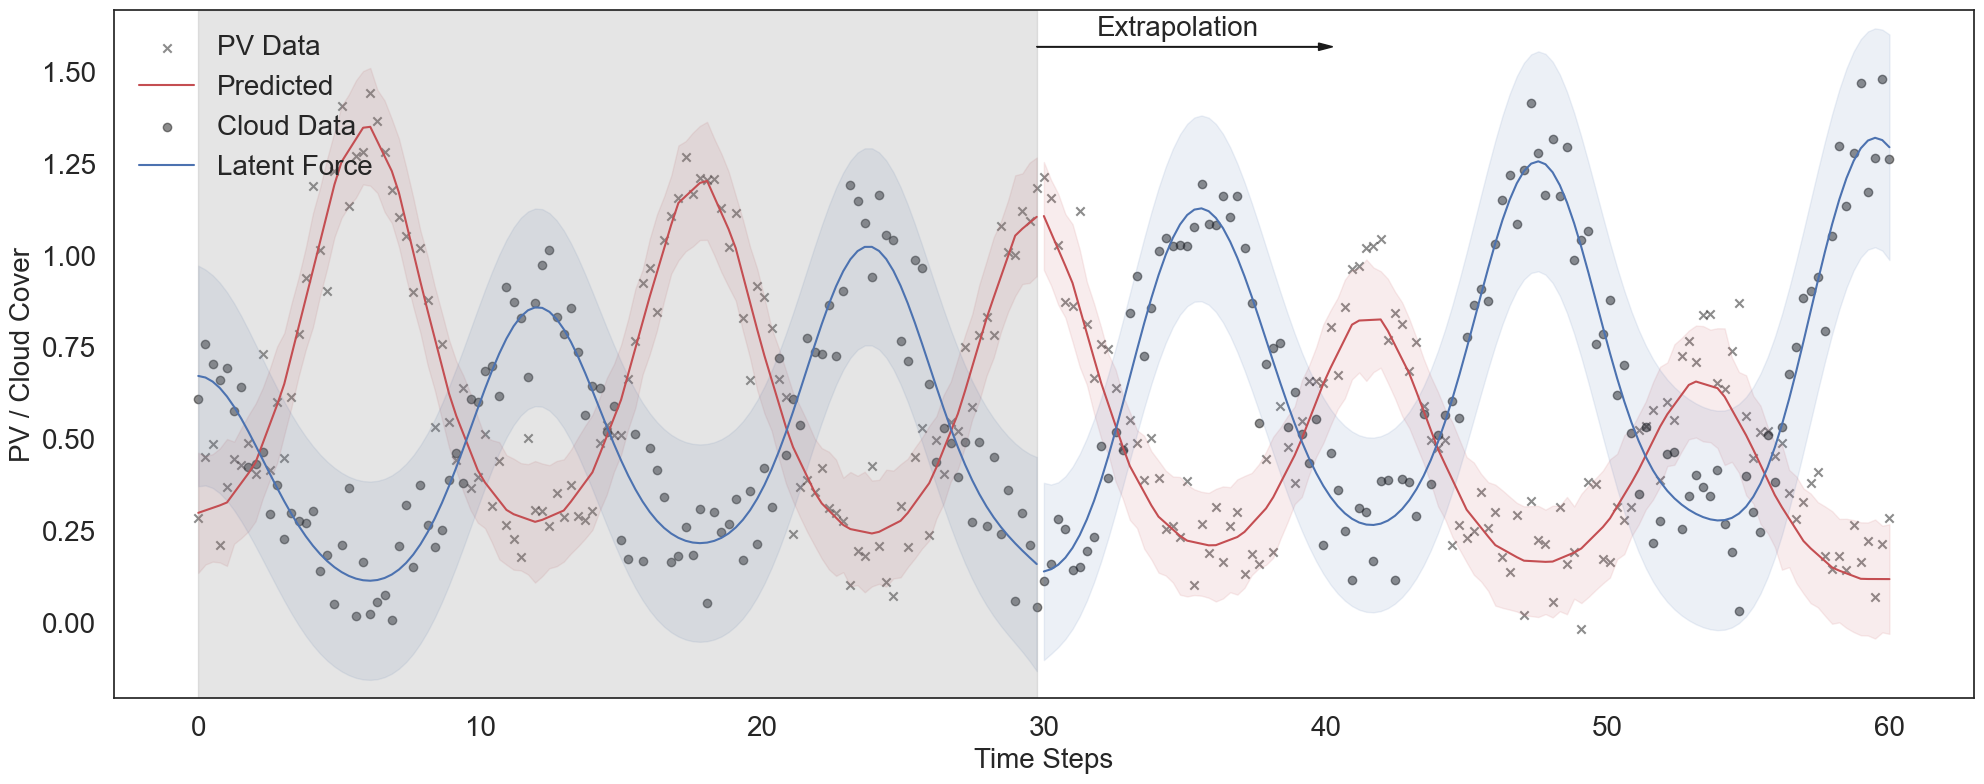

In [56]:
plot_lfm(model, dataset, gp_model)